## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [2]:
# Load data
train_df = pd.read_csv('../datasets/train_data.csv')
val_df = pd.read_csv('../datasets/val_data.csv')
feature_cols = ['Packet speed', 'Data speed', 'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio',
                'Duration', 'Hour sin', 'Hour cos', 'Day of Week','Unique ports', 'Std packet speed', 'Max packet speed', 
                'Std data speed', 'Max data speed', 'Std packet length', 'Max packet length',
                'Std source IP count', 'Max source IP count', 'Mean time diff', 'Std time diff','pca_1','pca_2']

In [3]:
# Display a sample of the data
train_df.head()

,Unnamed: 0,Attack ID,Victim IP,Port number,Detect count,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,...,Std data speed,Max data speed,Std packet length,Max packet length,Std source IP count,Max source IP count,Mean time diff,Std time diff,pca_1,pca_2
0,0,1,IP_0001,4500,1,0.012829,0.035732,1383,6,2022-08-08 18:09:36,...,0.0,73,0.0,1383,0.0,6,0.0,0.0,5882.390147,-43.601836
1,1,2,IP_0002,4500,1,0.015076,0.044053,1506,1,2022-08-08 18:37:28,...,0.0,90,0.0,1506,0.0,1,0.0,0.0,77282.435588,23.576695
2,2,3,IP_0003,1200,2,0.014848,0.040137,1399,1,2022-08-08 18:41:25,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,12982.392646,-36.872210
3,3,4,IP_0002,4500,1,0.013938,0.041605,1486,1,2022-08-08 18:47:49,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,9782.400003,-39.903941
4,4,5,IP_0004,12347,2,0.019272,0.055311,1518,1,2022-08-08 18:57:15,...,0.0,85,0.0,1486,0.0,1,0.0,0.0,-48320.362374,-39.977475


## 2. Data Preparation

In [4]:
# Prepare training and testing datasets
X_train = train_df[feature_cols] 
y_train = train_df['Type']       

X_test = val_df[feature_cols]      
y_test = val_df['Type']            

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 2.1 Feature Scaling

In [5]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.2 SMOTE for Class Imbalance

In [6]:
# Check class distribution before SMOTE
print("Original class distribution:")
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(sampling_strategy={'Normal traffic': 249013, 
                                 'Suspicious traffic': 50000, 
                                 'DDoS attack': 5000}, random_state=42)

class_mapping =  {}
for i, class_name in enumerate(le.classes_):
        class_mapping[class_name] = i
print(class_mapping)
smote_encoded = SMOTE(sampling_strategy={class_mapping['Normal traffic']: 249013,
                                        class_mapping['Suspicious traffic']: 50000,
                                        class_mapping['DDoS attack']: 5000},random_state=42)

# For regular data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# For scaled data
X_train_smote_scaled, y_train_smote_encoded = smote_encoded.fit_resample(X_train_scaled, y_train_encoded)

# Check class distribution after SMOTE
print("\nResampled class distribution:")
print(y_train_smote.value_counts())

Original class distribution:
Type
Normal traffic        249013
Suspicious traffic     13380
DDoS attack             2373
Name: count, dtype: int64
{'DDoS attack': 0, 'Normal traffic': 1, 'Suspicious traffic': 2}

Resampled class distribution:
Type
Normal traffic        249013
Suspicious traffic     50000
DDoS attack             5000
Name: count, dtype: int64


## 3. Modeling

We'll evaluate each model with:
1. Original data
2. Scaled data
3. SMOTE-resampled data
4. Scaled + SMOTE data

In [7]:
# Dictionary to store results for final comparison
results = {}

# Function to evaluate model and store results
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, data_type):
    # Train model
    model.fit(X_train_data, y_train_data)

    # Predict and evaluate
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred, average="macro")
    precision = precision_score(y_test_data, y_pred, average="macro")
    f1 = f1_score(y_test_data, y_pred, average="macro")
    conf_matrix = confusion_matrix(y_test_data, y_pred)

    # Print results
    print(f"{model_name} with {data_type}")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Store results
    results[f"{model_name} ({data_type})"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }

    return model, y_pred, conf_matrix
    

def plot_conf_matrix(cm, model_name, data_type, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - {data_type}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

### 3.1 Random Forest

Random Forest with original data
Accuracy: 0.4264, Recall: 0.5485, Precision: 0.6599, F1-score: 0.4839
Confusion Matrix:
[[  507   529    19]
 [73249 52643     1]
 [  311   462  2279]]


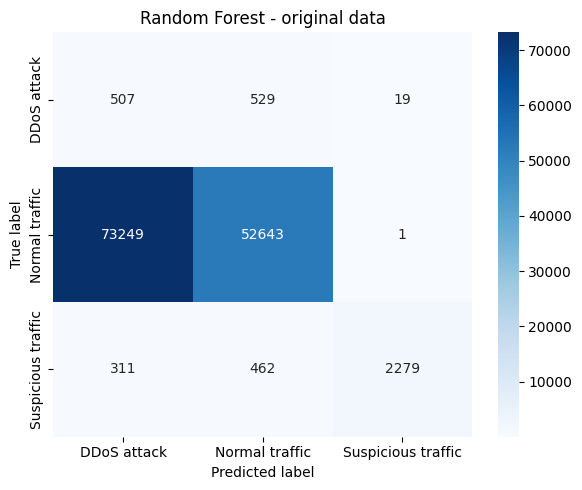

In [8]:
# 1. Random Forest with original data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original, y_pred_rf, conf_rf = evaluate_model(
    rf_model, X_train, y_train, X_test, y_test, 
    "Random Forest", "original data"
)
plot_conf_matrix(conf_rf, "Random Forest", "original data", le.classes_)

Random Forest with scaled data
Accuracy: 0.4428, Recall: 0.5552, Precision: 0.6593, F1-score: 0.4903
Confusion Matrix:
[[  505   527    23]
 [71123 54765     5]
 [  325   432  2295]]


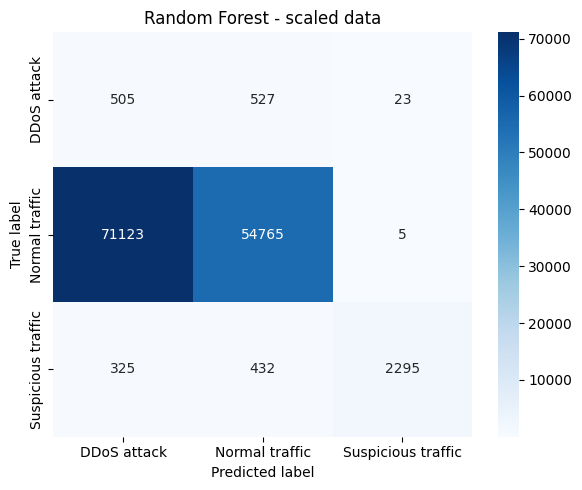

In [9]:
# 2. Random Forest with scaled data
rf_scaled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scaled_model, y_pred_rf_scaled, conf_rf_scaled = evaluate_model(
    rf_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "Random Forest", "scaled data"
)
plot_conf_matrix(conf_rf_scaled, "Random Forest", "scaled data", le.classes_)

Random Forest with SMOTE data
Accuracy: 0.4240, Recall: 0.4877, Precision: 0.6002, F1-score: 0.4153
Confusion Matrix:
[[  538   489    28]
 [72585 52951   357]
 [ 1109   318  1625]]


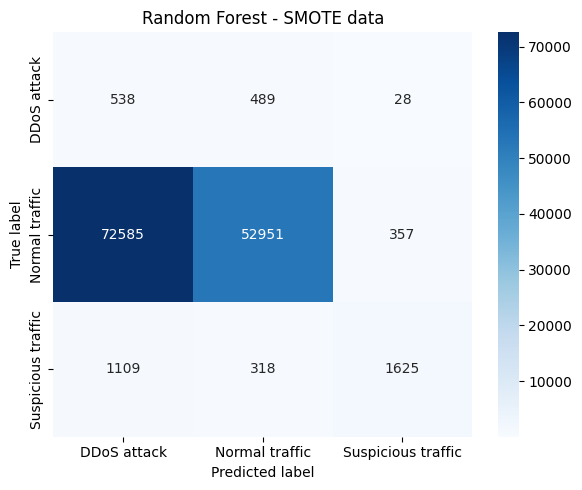

In [10]:
# 3. Random Forest with SMOTE data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_model, y_pred_rf_smote, conf_rf_smote = evaluate_model(
    rf_smote, X_train_smote, y_train_smote, X_test, y_test, 
    "Random Forest", "SMOTE data"
)
plot_conf_matrix(conf_rf_smote, "Random Forest", "SMOTE data", le.classes_)

Random Forest with SMOTE + scaled data
Accuracy: 0.4402, Recall: 0.4820, Precision: 0.6204, F1-score: 0.4224
Confusion Matrix:
[[  520   508    27]
 [70541 55139   213]
 [ 1224   256  1572]]


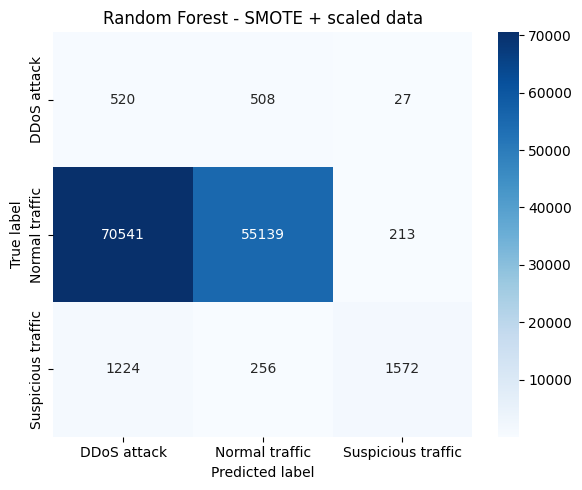

In [11]:
# 4. Random Forest with SMOTE + scaled data
rf_smote_scaled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_scaled_model, y_pred_rf_smote_scaled, conf_rf_smote_scaled = evaluate_model(
    rf_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "Random Forest", "SMOTE + scaled data"
)
plot_conf_matrix(conf_rf_smote_scaled, "Random Forest", "SMOTE + scaled data", le.classes_)

### 3.2 SVM

LinearSVC with original data
Accuracy: 0.9695, Recall: 0.3697, Precision: 0.6571, F1-score: 0.3908
Confusion Matrix:
[[     2   1028     25]
 [     1 125696    196]
 [     2   2718    332]]


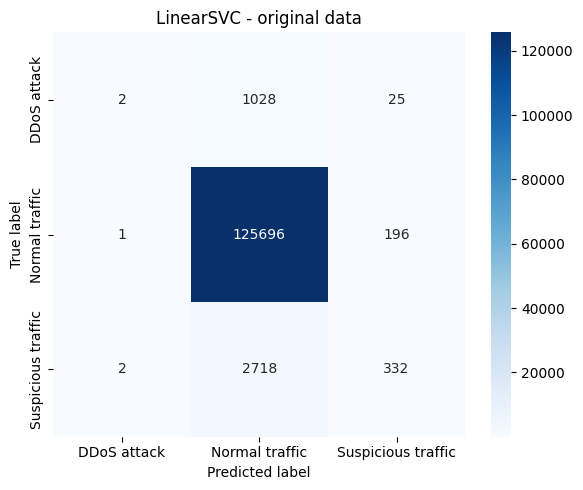

In [12]:
# 1. SVM with original data
svm_model = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_original, y_pred_svm, conf_svm = evaluate_model(
    svm_model, X_train, y_train_encoded, X_test, y_test_encoded, 
    "LinearSVC", "original data"
)
plot_conf_matrix(conf_svm, "LinearSVC", "original data", le.classes_)

LinearSVC with scaled data
Accuracy: 0.9644, Recall: 0.5228, Precision: 0.7518, F1-score: 0.4999
Confusion Matrix:
[[    17    945     93]
 [     1 123613   2279]
 [     2   1309   1741]]


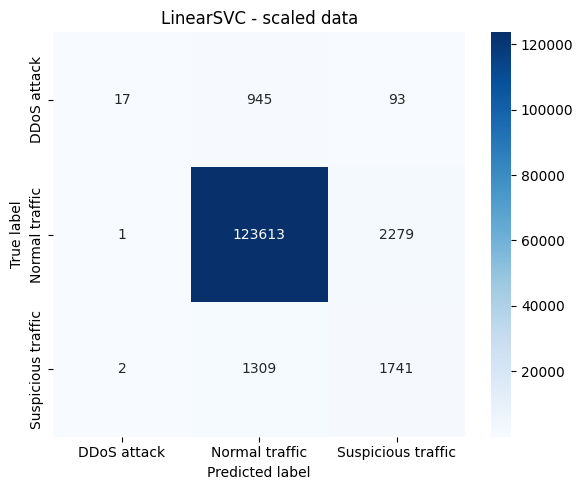

In [13]:
# 2. SVM with scaled data
svm_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_scaled_model, y_pred_svm_scaled, conf_svm_scaled = evaluate_model(
    svm_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "scaled data"
)
plot_conf_matrix(conf_svm_scaled, "LinearSVC", "scaled data", le.classes_)

LinearSVC with SMOTE data
Accuracy: 0.9618, Recall: 0.4843, Precision: 0.4912, F1-score: 0.4711
Confusion Matrix:
[[     8    997     50]
 [    40 123613   2240]
 [    23   1615   1414]]


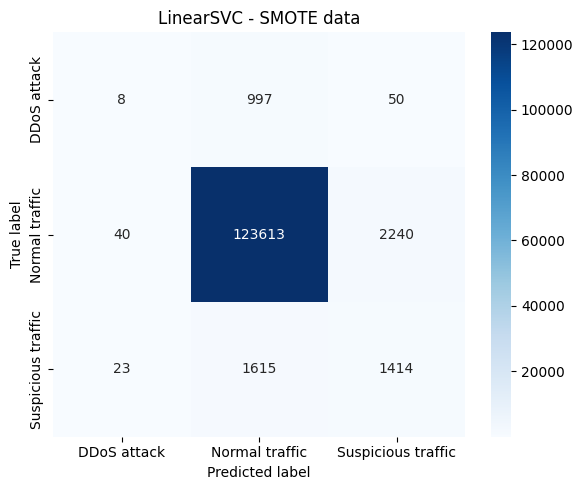

In [14]:
# 3. SVM with SMOTE data
svm_smote = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_model, y_pred_svm_smote, conf_svm_smote = evaluate_model(
    svm_smote, X_train_smote, y_train_smote_encoded, X_test, y_test_encoded, 
    "LinearSVC", "SMOTE data"
)
plot_conf_matrix(conf_svm_smote, "LinearSVC", "SMOTE data", le.classes_)

LinearSVC with SMOTE + scaled data
Accuracy: 0.9485, Recall: 0.6110, Precision: 0.6816, F1-score: 0.4980
Confusion Matrix:
[[    27    873    155]
 [     5 120688   5200]
 [     5    457   2590]]


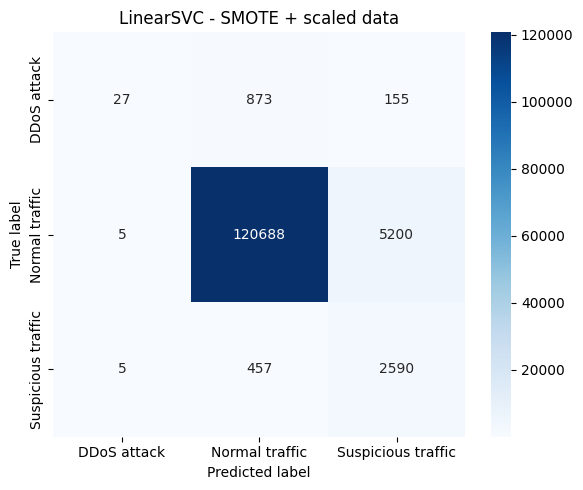

In [15]:
# 4. SVM with SMOTE + scaled data
svm_smote_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_scaled_model, y_pred_svm_smote_scaled, conf_svm_smote_scaled = evaluate_model(
    svm_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "SMOTE + scaled data"
)
plot_conf_matrix(conf_svm_smote_scaled, "LinearSVC", "SMOTE + scaled data", le.classes_)

### 3.3 XGBoost

XGBoost with original data
Accuracy: 0.4568, Recall: 0.5627, Precision: 0.6608, F1-score: 0.4933
Confusion Matrix:
[[  524   505    26]
 [69293 56600     0]
 [  501   287  2264]]


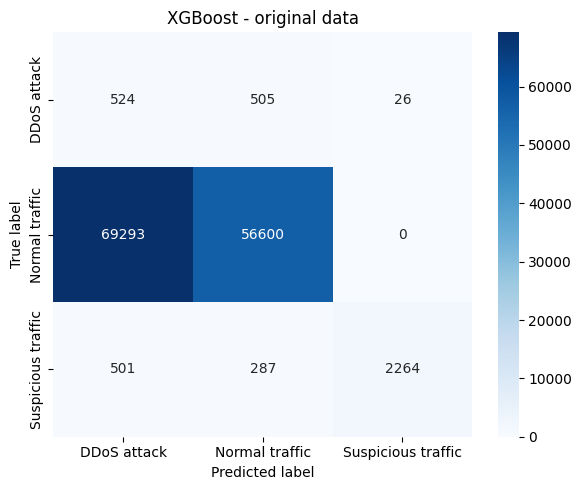

In [16]:
# 1. XGBoost with original data
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_original, y_pred_xgb, conf_xgb = evaluate_model(
    xgb_model, X_train, y_train_encoded, X_test, y_test_encoded, 
    "XGBoost", "original data"
)
plot_conf_matrix(conf_xgb, "XGBoost", "original data", le.classes_)

XGBoost with scaled data
Accuracy: 0.4678, Recall: 0.5629, Precision: 0.6611, F1-score: 0.4939
Confusion Matrix:
[[  528   503    24]
 [67824 58069     0]
 [  539   294  2219]]


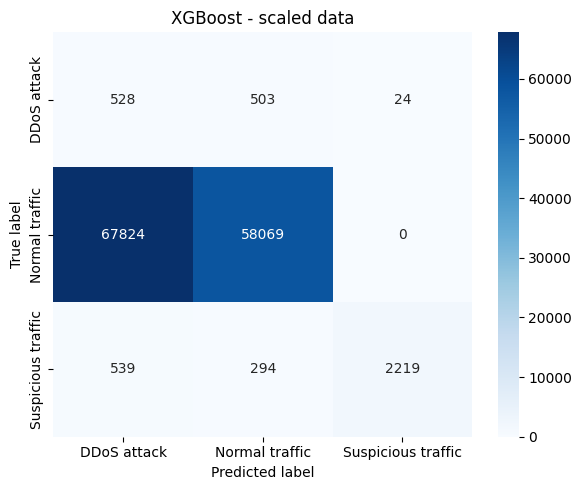

In [17]:
# 2. XGBoost with scaled data
xgb_scaled = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_scaled_model, y_pred_xgb_scaled, conf_xgb_scaled = evaluate_model(
    xgb_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "XGBoost", "scaled data"
)
plot_conf_matrix(conf_xgb_scaled, "XGBoost", "scaled data", le.classes_)

XGBoost with SMOTE data
Accuracy: 0.5348, Recall: 0.5146, Precision: 0.5673, F1-score: 0.4350
Confusion Matrix:
[[  525   512    18]
 [57827 67447   619]
 [  861   633  1558]]


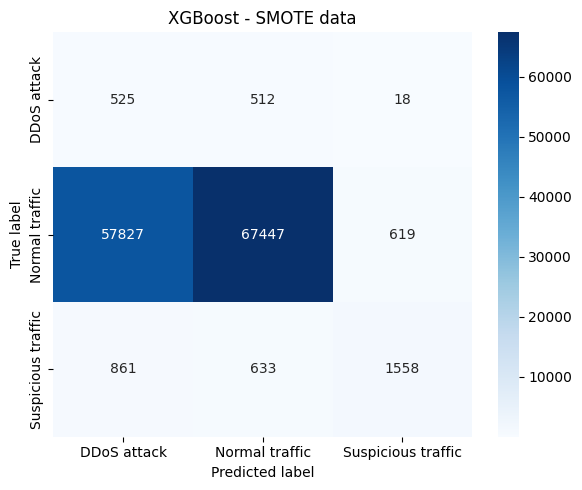

In [18]:
# 3. XGBoost with SMOTE data
xgb_smote = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_smote_model, y_pred_xgb_smote, conf_xgb_smote = evaluate_model(
    xgb_smote, X_train_smote, y_train_smote_encoded, X_test, y_test_encoded, 
    "XGBoost", "SMOTE data"
)
plot_conf_matrix(conf_xgb_smote, "XGBoost", "SMOTE data", le.classes_)

XGBoost with SMOTE + scaled data
Accuracy: 0.7068, Recall: 0.6594, Precision: 0.6518, F1-score: 0.5682
Confusion Matrix:
[[  526   496    33]
 [36795 89006    92]
 [  465   229  2358]]


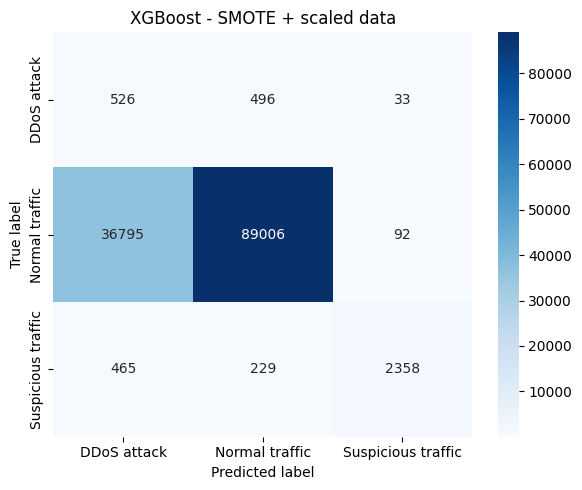

In [19]:
# 4. XGBoost with SMOTE + scaled data
xgb_smote_scaled = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_smote_scaled_model, y_pred_xgb_smote_scaled, conf_xgb_smote_scaled = evaluate_model(
    xgb_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "XGBoost", "SMOTE + scaled data"
)
plot_conf_matrix(conf_xgb_smote_scaled, "XGBoost", "SMOTE + scaled data", le.classes_)

In [20]:
# 5. Defining more models

bagging_model = BaggingClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

voting_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)),
        ('knn', KNeighborsClassifier())
    ],
    voting='hard'
)

Bagging with original data
Accuracy: 0.4331, Recall: 0.5947, Precision: 0.6555, F1-score: 0.5065
Confusion Matrix:
[[  527   491    37]
 [72708 53147    38]
 [  213   207  2632]]
AdaBoost with original data
Accuracy: 0.9678, Recall: 0.6139, Precision: 0.5385, F1-score: 0.5699
Confusion Matrix:
[[    33    914    108]
 [  1068 123242   1583]
 [   214    300   2538]]
GradientBoosting with original data
Accuracy: 0.4266, Recall: 0.3431, Precision: 0.6044, F1-score: 0.2308
Confusion Matrix:
[[  586   459    10]
 [71131 54747    15]
 [ 2218   715   119]]
CatBoost with original data
Accuracy: 0.8161, Recall: 0.7100, Precision: 0.6553, F1-score: 0.6047
Confusion Matrix:
[[   531    495     29]
 [ 22696 103100     97]
 [   249    338   2465]]
Voting with original data
Accuracy: 0.4839, Recall: 0.5044, Precision: 0.6604, F1-score: 0.4623
Confusion Matrix:
[[  484   555    16]
 [65212 60681     0]
 [  805   500  1747]]


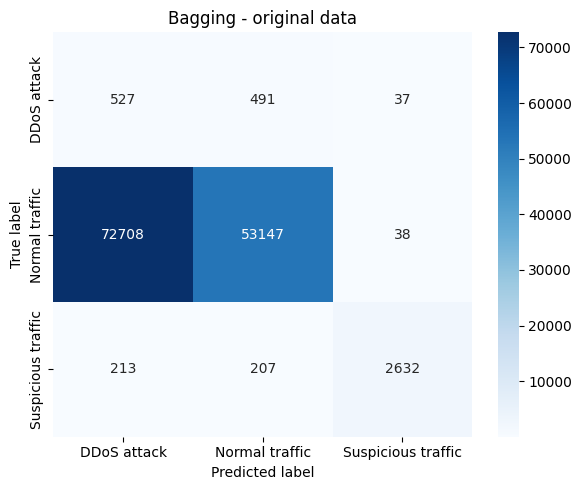

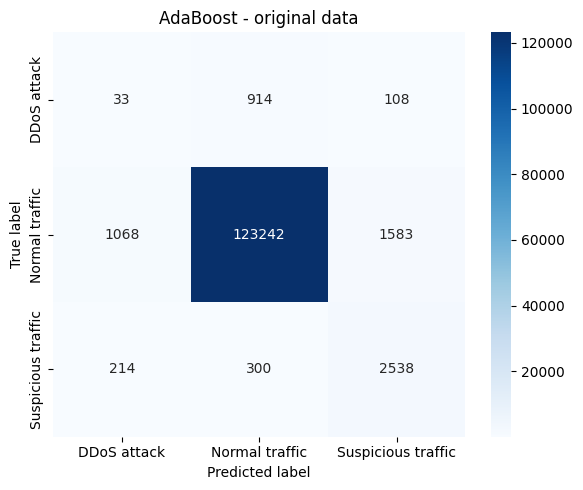

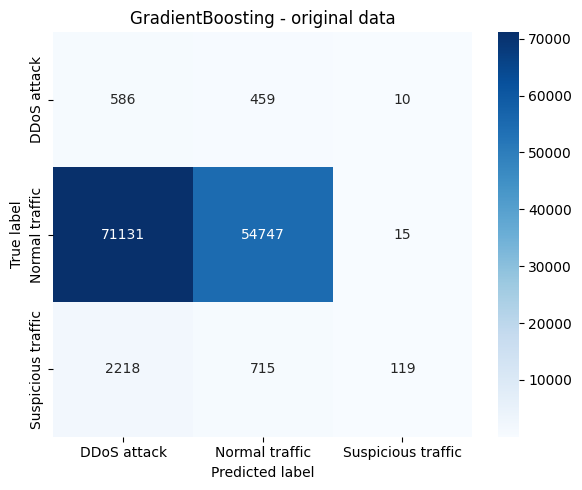

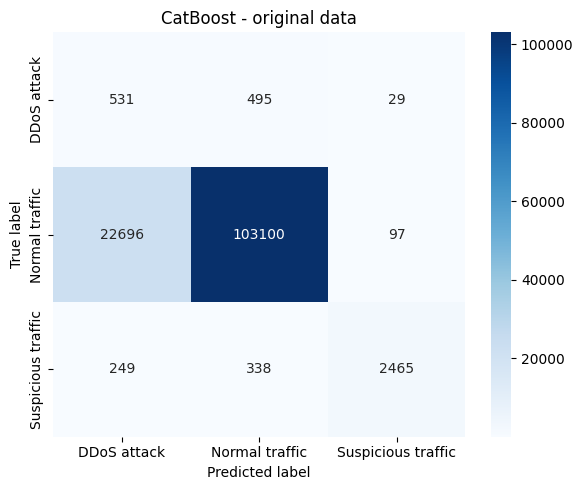

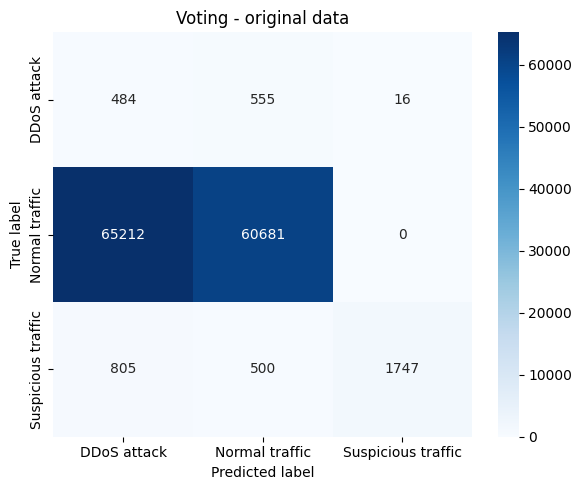

In [21]:
bagging_result, y_pred_bagging, conf_bagging = evaluate_model(
    bagging_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "Bagging", "original data"
)

ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "AdaBoost", "original data"
)

gb_result, y_pred_gb, conf_gb = evaluate_model(
    gb_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "GradientBoosting", "original data"
)

catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "CatBoost", "original data"
)

voting_result, y_pred_vote, conf_vote = evaluate_model(
    voting_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "Voting", "original data"
)



plot_conf_matrix(conf_bagging, "Bagging", "original data", le.classes_)
plot_conf_matrix(conf_ada, "AdaBoost", "original data", le.classes_)
plot_conf_matrix(conf_gb, "GradientBoosting", "original data", le.classes_)
plot_conf_matrix(conf_cat, "CatBoost", "original data", le.classes_)
plot_conf_matrix(conf_vote, "Voting", "original data", le.classes_)


In [22]:
# Create a new voting classifier without problematic estimators
# voting_model2 = VotingClassifier(
#     estimators=[
#         ('ada', AdaBoostClassifier(random_state=42)),
#         ('cat', CatBoostClassifier(verbose=0, random_state=42)),  # Regular CatBoost
#         ('svc', SVC(probability=True, random_state=42))  # SVC with probability=True
#     ],
#     voting='hard'
# )

# voting_result2, y_pred_vote2, conf_vote2 = evaluate_model(
#     voting_model2, X_train, y_train_encoded, X_test, y_test_encoded,
#     "Voting 2", "original data"
# )

# plot_conf_matrix(conf_vote2, "Voting 2", "original data", le.classes_)

### 3.4 Feature importances and rf with only using top features

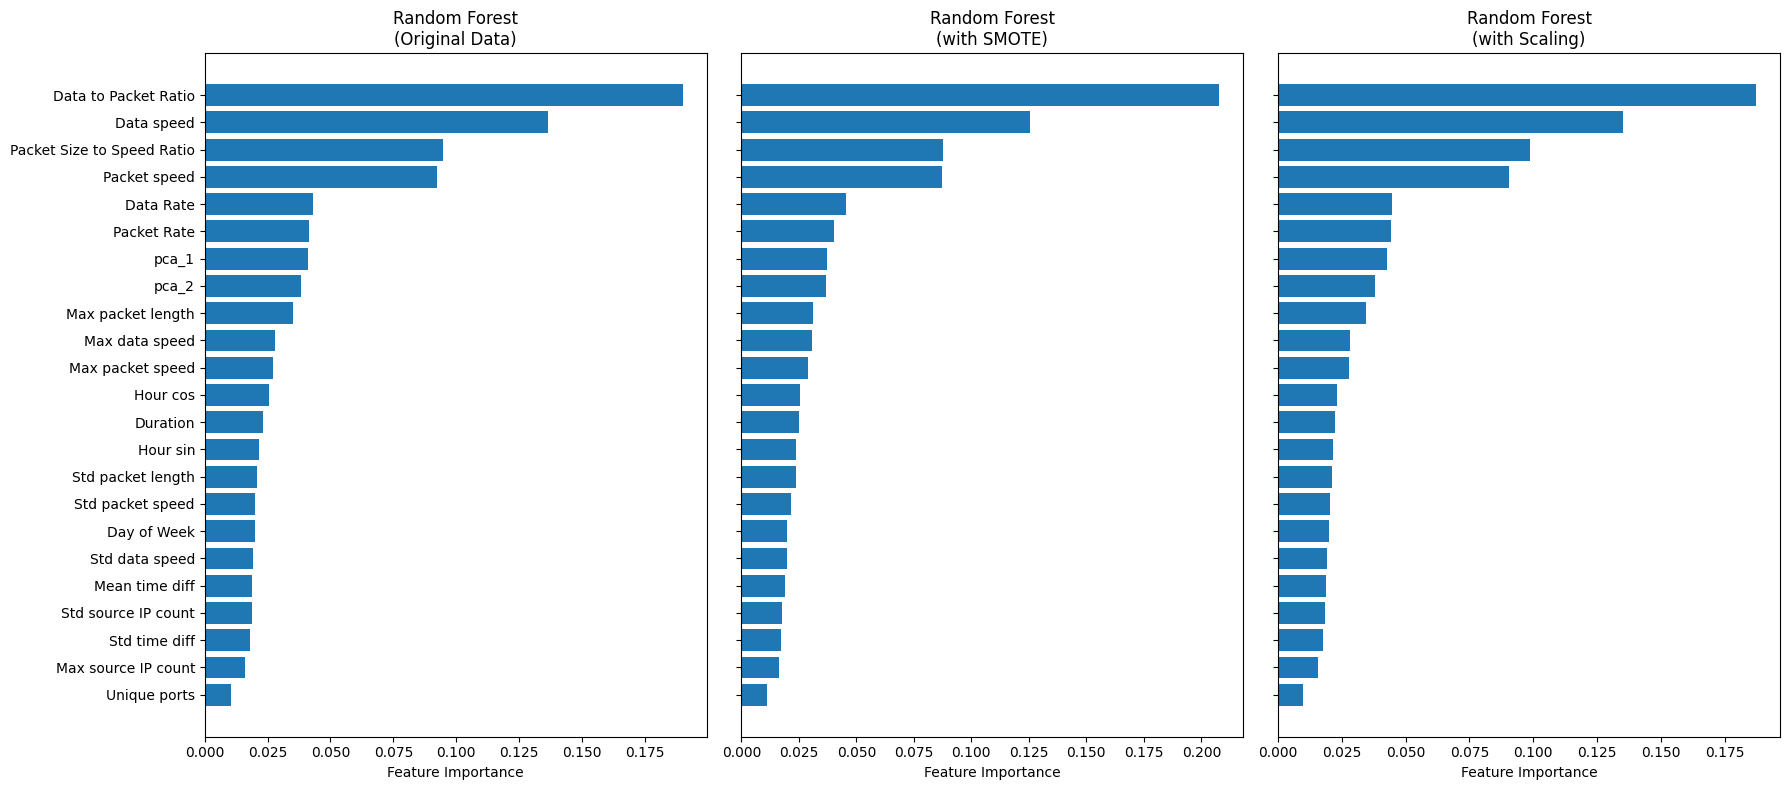

In [23]:
# Random Forest Feature Importance
feature_importances_rf = rf_original.feature_importances_
feature_importances_rf_smote = rf_smote_model.feature_importances_
feature_importances_rf_scale = rf_scaled_model.feature_importances_

# Visualize feature importance for the three RF models
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Sort the features by importance for better visualization
def plot_feature_importance(ax, importances, title):
    # Create array of feature importance with feature names as index
    indices = np.argsort(importances)
    
    # Plot the feature importance in descending order
    ax.barh(range(len(importances)), importances[indices], align='center')
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels([feature_cols[i] for i in indices])
    ax.set_title(title)
    ax.set_xlabel('Feature Importance')

# Plot for the standard Random Forest model
plot_feature_importance(axes[0], feature_importances_rf, 'Random Forest\n(Original Data)')

# Plot for Random Forest with SMOTE
plot_feature_importance(axes[1], feature_importances_rf_smote, 'Random Forest\n(with SMOTE)')

# Plot for Scaled Random Forest
plot_feature_importance(axes[2], feature_importances_rf_scale, 'Random Forest\n(with Scaling)')

plt.tight_layout()
plt.show()

Random Forest with top features + scaled data
Accuracy: 0.3255, Recall: 0.5655, Precision: 0.6606, F1-score: 0.4581
Confusion Matrix:
[[  614   419    22]
 [86646 39246     1]
 [  385   217  2450]]


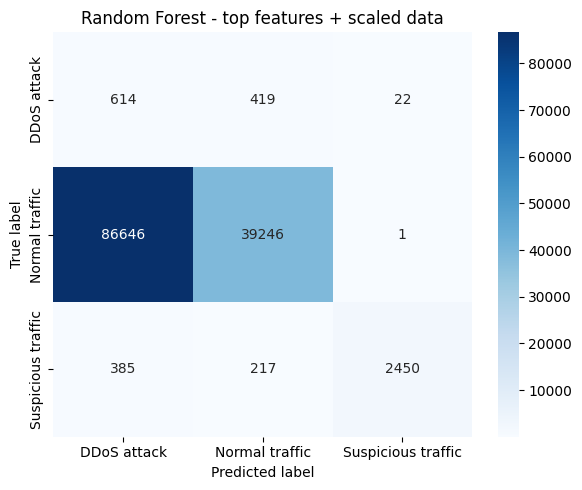

In [24]:
# Train with only the top features
top_features = ['Data to Packet Ratio', 'Data speed', 'Packet speed', 
                'Packet Size to Speed Ratio', 'pca_1', 'Packet Rate', 'pca_2']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale these features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train model with just these features
rf_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top, y_pred_top, conf_top = evaluate_model(
    rf_top_features, X_train_top_scaled, y_train_encoded, X_test_top_scaled, y_test_encoded, 
    "Random Forest", "top features + scaled data"
)

plot_conf_matrix(conf_top, "Random Forest", "top features + scaled data", le.classes_)

### 3.5 Binary Classification

Random Forest Binary with scaled data (Normal vs Attack)
Accuracy: 0.3341, Recall: 0.4288, Precision: 0.4974, F1-score: 0.2552
Confusion Matrix:
[[  554   501]
 [86063 42882]]


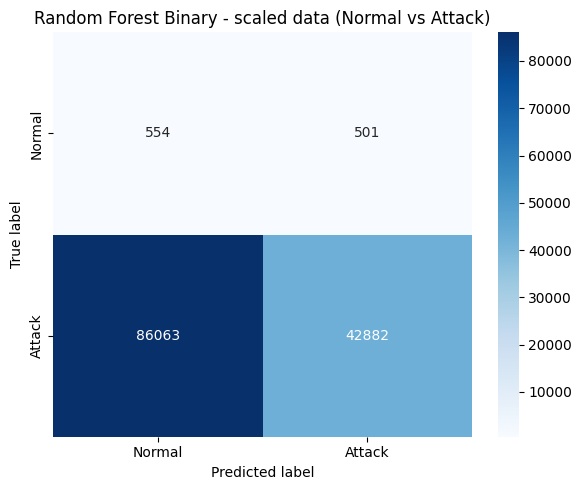

In [25]:
# Binary class version (Normal vs Any-Attack)
y_train_binary = (y_train_encoded != 0).astype(int)  # 0=Normal, 1=Any attack
y_test_binary = (y_test_encoded != 0).astype(int)

# Train binary classifier on scaled data
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary_model, y_pred_binary, conf_binary = evaluate_model(
    rf_binary, X_train_scaled, y_train_binary, X_test_scaled, y_test_binary, 
    "Random Forest Binary", "scaled data (Normal vs Attack)"
)

plot_conf_matrix(conf_binary, "Random Forest Binary", "scaled data (Normal vs Attack)", ["Normal", "Attack"])

### 3.6 Neural network

In [26]:
!pip install -q pytorch-lightning
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.2/316.2 kB 7.3 MB/s eta 0:00:00a 0:00:01


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
import torchmetrics

In [28]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [29]:
batch_size = 64
epochs = 20
lr = 0.002
hidden_dim = 64

In [30]:
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(X_train_smote_scaled, y_train_smote_encoded, test_size=0.2, random_state=42)

In [31]:
def create_dataloader(X, y, batch_size):
  X = scaler.transform(X).astype('float32')
  X = torch.from_numpy(X)
  y = y.astype('long')
  y = torch.from_numpy(y)
  dataset = TensorDataset(X, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 15)
  return dataloader

train_loader = create_dataloader(X_nn_train, y_nn_train, batch_size)
val_loader = create_dataloader(X_nn_val, y_nn_val, batch_size)
test_loader = create_dataloader(X_test, y_test_encoded, batch_size)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [32]:
import pytorch_lightning as pl
import torch.nn as nn
import torchmetrics

class MyFeedForwardNet(pl.LightningModule):
    def __init__(self, num_features, hidden_dim, lr, num_classes=3):
        super(MyFeedForwardNet, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)  # output logits for each class
        )

        self.loss = nn.CrossEntropyLoss()
        self.acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"loss": loss, "acc": acc}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=False)
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"test_loss": loss, "test_acc": acc})
        return {"test_loss": loss, "test_acc": acc}

    def _shared_eval_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.acc(preds, y)
        return loss, acc

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

In [33]:
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger(save_dir="logs/", name="ddos_logs")

In [34]:
model = MyFeedForwardNet(X_nn_train.shape[1], hidden_dim, lr)

# we use the ModelCheckpoint callback to save the best model
callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath = '',
    filename = 'best_model',
)

# we use the Trainer class to train our model
trainer = pl.Trainer(
    logger=logger,
    max_epochs=5,
    log_every_n_steps=100,
    callbacks=[callback],
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
torch.set_float32_matmul_precision('high')
trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory  exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | layers | Sequential         | 1.7 K  | train
1 | loss   | CrossEntropyLoss   | 0      | train
2 | acc    | MulticlassAccuracy | 0      | train
------------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [36]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.899476945400238     │
│         test_loss         │     1.245709776878357     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.245709776878357, 'test_acc': 0.899476945400238}]

In [37]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.03      0.28      0.06      1055
           1       0.97      0.93      0.95    125893
           2       0.00      0.00      0.00      3052

    accuracy                           0.90    130000
   macro avg       0.34      0.40      0.34    130000
weighted avg       0.94      0.90      0.92    130000



In [38]:
class FeedForwardNet(pl.LightningModule):
    def __init__(self, num_features, hidden_dim, lr, num_classes=3, dropout_prob=0.3):
        super(FeedForwardNet, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dim, num_classes)  # output layer (logits)
        )

        self.loss = nn.CrossEntropyLoss()
        self.acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"loss": loss, "acc": acc}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=False)
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"test_loss": loss, "test_acc": acc})
        return {"test_loss": loss, "test_acc": acc}

    def _shared_eval_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.acc(preds, y)
        return loss, acc

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

In [39]:
model = FeedForwardNet(X_nn_train.shape[1], hidden_dim, lr)

# we use the ModelCheckpoint callback to save the best model
callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath = '',
    filename = 'best_model_2',
)

# we use the Trainer class to train our model
trainer = pl.Trainer(
    logger=logger,
    max_epochs=5,
    log_every_n_steps=100,
    callbacks=[callback],
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory  exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | layers | Sequential         | 6.1 K  | train
1 | loss   | CrossEntropyLoss   | 0      | train
2 | acc    | MulticlassAccuracy | 0      | train
------------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.025     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
trainer.test(model, test_loader)

In [ ]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()
print(classification_report(y_true, y_pred))

## 4. Results Comparison

In [41]:
# Create DataFrame from results dictionary for easy comparison
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by=['Recall', 'Accuracy'], ascending=False)

# Display the results
print("Models Performance Summary (Sorted by Recall)")
results_df

Models Performance Summary (Sorted by Recall)


,Accuracy,Recall,Precision,F1-score
CatBoost (original data),81.61,71.00,65.53,60.47
XGBoost (SMOTE + scaled data),70.68,65.94,65.18,56.82
AdaBoost (original data),96.78,61.39,53.85,56.99
LinearSVC (SMOTE + scaled data),94.85,61.10,68.16,49.80
Bagging (original data),43.31,59.47,65.55,50.65
Random Forest (top features + scaled data),32.55,56.55,66.06,45.81
XGBoost (scaled data),46.78,56.29,66.11,49.39
XGBoost (original data),45.68,56.27,66.08,49.33
Random Forest (scaled data),44.28,55.52,65.93,49.03
Random Forest (original data),42.64,54.85,65.99,48.39


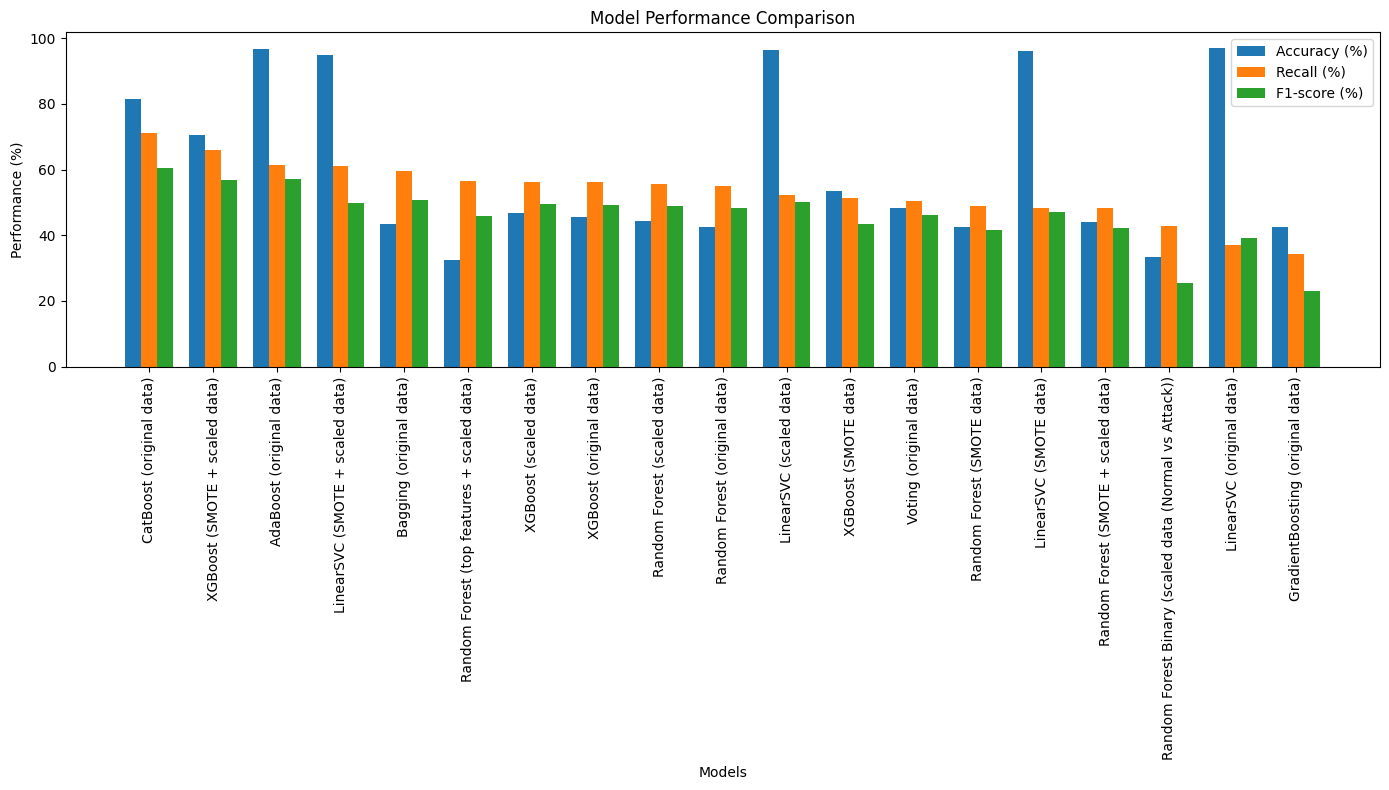

In [42]:
# Visualize the results
plt.figure(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(results_df))

plt.bar(index, results_df['Accuracy'], bar_width, label='Accuracy (%)')
plt.bar(index + bar_width, results_df['Recall'], bar_width, label='Recall (%)')
plt.bar(index + 2 * bar_width, results_df['F1-score'], bar_width, label='F1-score (%)')

plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width, results_df.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Szűrés

In [43]:
train_df_filtered = train_df[train_df['Avg packet len'] != 0].reset_index(drop=True)
val_df_filtered = val_df[val_df['Avg packet len'] != 0].reset_index(drop=True)

In [44]:
# Prepare training and testing datasets
X_train = train_df_filtered[feature_cols] 
y_train = train_df_filtered['Type']       

X_test = val_df_filtered[feature_cols]      
y_test = val_df_filtered['Type']            

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

AdaBoost with original data
Accuracy: 0.9678, Recall: 0.6139, Precision: 0.5385, F1-score: 0.5699
Confusion Matrix:
[[    33    914    108]
 [  1068 123242   1583]
 [   214    300   2538]]
CatBoost with original data
Accuracy: 0.8161, Recall: 0.7100, Precision: 0.6553, F1-score: 0.6047
Confusion Matrix:
[[   531    495     29]
 [ 22696 103100     97]
 [   249    338   2465]]


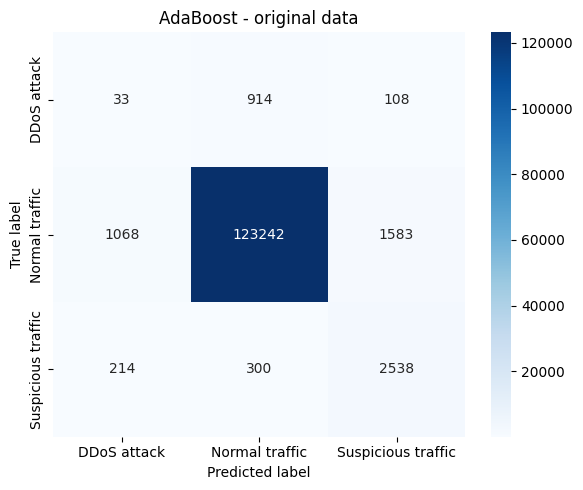

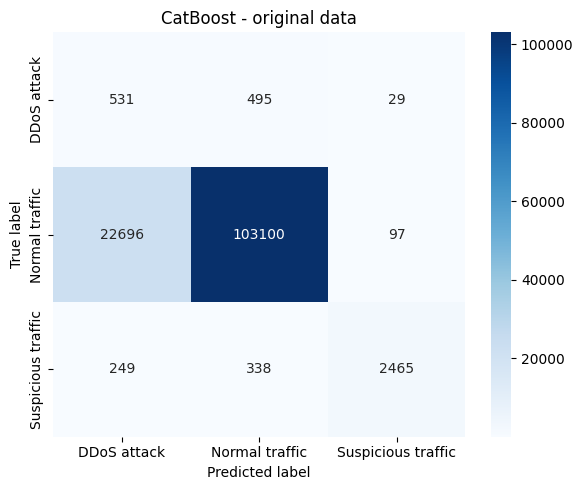

In [45]:
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "AdaBoost", "original data"
)

catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "CatBoost", "original data"
)

plot_conf_matrix(conf_ada, "AdaBoost", "original data", le.classes_)
plot_conf_matrix(conf_cat, "CatBoost", "original data", le.classes_)

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
y_train.value_counts()

Type
Normal traffic        249013
Suspicious traffic     13380
DDoS attack             2373
Name: count, dtype: int64

In [49]:
# Check class distribution before SMOTE
print("Original class distribution:")
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(sampling_strategy={'Normal traffic': 249013, 
                                 'Suspicious traffic': 50000, 
                                 'DDoS attack': 5000}, random_state=42)

class_mapping =  {}
for i, class_name in enumerate(le.classes_):
        class_mapping[class_name] = i
print(class_mapping)
smote_encoded = SMOTE(sampling_strategy={class_mapping['Normal traffic']: 249013,
                                        class_mapping['Suspicious traffic']: 50000,
                                        class_mapping['DDoS attack']: 5000},random_state=42)

# For regular data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# For scaled data
X_train_smote_scaled, y_train_smote_encoded = smote_encoded.fit_resample(X_train_scaled, y_train_encoded)

# Check class distribution after SMOTE
print("\nResampled class distribution:")
print(y_train_smote.value_counts())

Original class distribution:
Type
Normal traffic        249013
Suspicious traffic     13380
DDoS attack             2373
Name: count, dtype: int64
{'DDoS attack': 0, 'Normal traffic': 1, 'Suspicious traffic': 2}

Resampled class distribution:
Type
Normal traffic        249013
Suspicious traffic     50000
DDoS attack             5000
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AdaBoost with original data
Accuracy: 0.9684, Recall: 0.3333, Precision: 0.3228, F1-score: 0.3280
Confusion Matrix:
[[     0   1055      0]
 [     0 125893      0]
 [     0   3052      0]]
CatBoost with original data
Accuracy: 0.0080, Recall: 0.3270, Precision: 0.3516, F1-score: 0.0059
Confusion Matrix:
[[  1034      0     21]
 [125852      1     40]
 [  3049      0      3]]


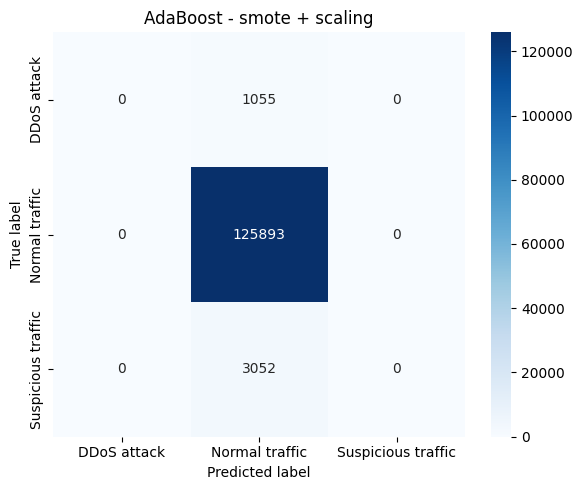

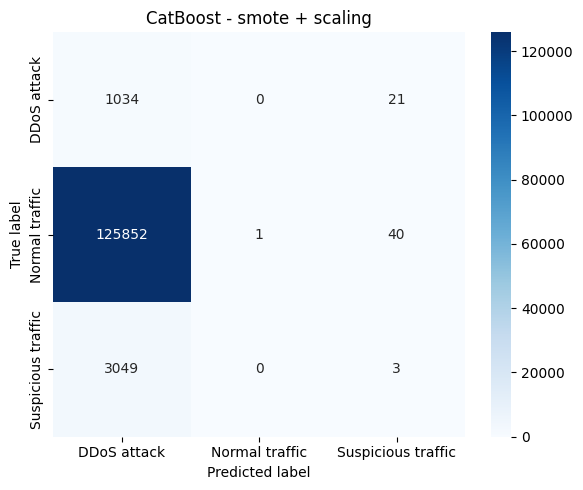

In [50]:
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train_smote_scaled, y_train_smote_encoded, X_test, y_test_encoded,
    "AdaBoost", "original data"
)

catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train_smote_scaled, y_train_smote_encoded, X_test, y_test_encoded,
    "CatBoost", "original data"
)

plot_conf_matrix(conf_ada, "AdaBoost", "smote + scaling", le.classes_)
plot_conf_matrix(conf_cat, "CatBoost", "smote + scaling", le.classes_)

LinearSVC with SMOTE + scaled data
Accuracy: 0.9485, Recall: 0.6110, Precision: 0.6816, F1-score: 0.4980
Confusion Matrix:
[[    27    873    155]
 [     5 120688   5200]
 [     5    457   2590]]


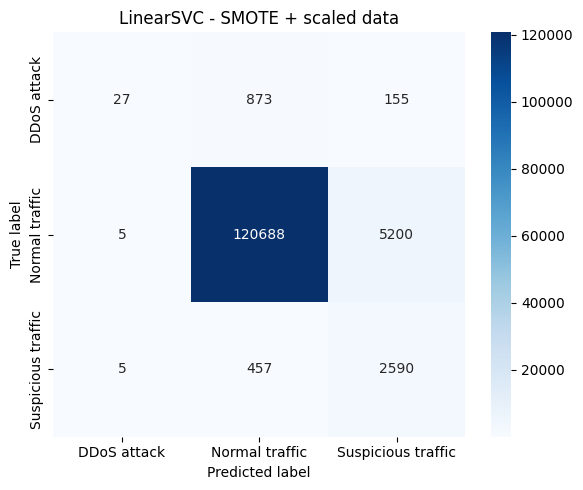

In [51]:
svm_smote_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_scaled_model, y_pred_svm_smote_scaled, conf_svm_smote_scaled = evaluate_model(
    svm_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "SMOTE + scaled data"
)
plot_conf_matrix(conf_svm_smote_scaled, "LinearSVC", "SMOTE + scaled data", le.classes_)

In [52]:
results_df2 = pd.DataFrame.from_dict(results, orient='index')
results_df2 = results_df.sort_values(by=['Recall', 'Accuracy'], ascending=False)

# Display the results
print("Models Performance Summary (Sorted by Recall)")
results_df2

Models Performance Summary (Sorted by Recall)


,Accuracy,Recall,Precision,F1-score
CatBoost (original data),81.61,71.00,65.53,60.47
XGBoost (SMOTE + scaled data),70.68,65.94,65.18,56.82
AdaBoost (original data),96.78,61.39,53.85,56.99
LinearSVC (SMOTE + scaled data),94.85,61.10,68.16,49.80
Bagging (original data),43.31,59.47,65.55,50.65
Random Forest (top features + scaled data),32.55,56.55,66.06,45.81
XGBoost (scaled data),46.78,56.29,66.11,49.39
XGBoost (original data),45.68,56.27,66.08,49.33
Random Forest (scaled data),44.28,55.52,65.93,49.03
Random Forest (original data),42.64,54.85,65.99,48.39
